# Module 0: Introduction

This notebook demonstrates how to build a production-ready AI agent that automates the mortgage pre-approval process.

## What You'll Learn
This notebook guides you through building a fully functional mortgage pre-approval AI agent following our proven six-step framework:

1. **Defining the scope of your AI Agent**: Clearly outline the business problem, success metrics, and workflow
2. **Selecting the large language model**: Choose the right model to power your agent based on specific requirements and architectural needs
3. **Creating the agent's tools**: Build specialized functions that give your agent abilities to take actions
4. **Orchestrating workflows**: Design the system that brings everything together into a seamless process
5. **Evaluating performance**: Test and refine your agent to ensure reliability and accuracy
6. **Deploy to production**: Move your agent from development to real-world use

## What is an AI Agent?
AI agents are advanced software programs designed to independently reason, access information from various sources, and execute intricate tasks across the enterprise.

Equipped with specialized tools — connections to company-wide systems — they navigate complex workflows step by step, delivering efficiency and precision with minimal human intervention.

These applications redefine how businesses work, enabling scalable operations, smarter decision-making, and seamless integration across systems.

## Why Use AI Agents for Mortgage Processing?
Mortgage processing involves numerous manual tasks ideal for automation:
- Credit checks across multiple bureaus
- Employment verification
- Document processing and report generation

By automating these processes, institutions can reduce processing time from hours to minutes, improve accuracy, and let loan officers focus on customer relationships.

# ⚠️ IMPORTANT: Generate Your Cohere API Key ⚠️

Before continuing, you must generate an API key from Cohere:

1. Go to [https://dashboard.cohere.com/welcome/register](https://dashboard.cohere.com/welcome/register)
2. Create an account or sign in
3. Navigate to API keys section
4. Generate a new API key
5. Copy your API key
6. Replace "your-api-key-here" in the cell below with your actual key

This notebook will not function without a valid API key.

In [ ]:
#Install necessary packages for notebook
!pip install cohere ragas datasets

In [2]:
# Import necessary libraries for the project
import os
import cohere
import json
import datetime

COHERE_API_KEY = "your-api-key-here"  # Replace with your actual API key

# Initialize Cohere client
co_client = cohere.ClientV2(api_key=COHERE_API_KEY)

# Print confirmation message
print("Module 1 complete: Environment and dependencies initialized.")

Module 1 complete: Environment and dependencies initialized.


# Module 1: Define the scope of your AI Agent

Begin by clearly defining your agent's purpose by interviewing stakeholders and gathering requirements. Document the specific business problem you're solving and outline measurable success criteria.

## Business Problem
Loan officers spend an average of five hours gathering and verifying information for each pre-approval request. This manual process includes checking credit scores, verifying employment, and writing summary reports.

## Success Metrics
* Increase loans processed by 3x in the first year of agent deployment
* Decrease loan officer analysis time from five hours to five minutes
* 98% credit check accuracy (on par with human-level)

## Required Actions
* Receive customer information (triggered by the submission of a mortgage application)
* Build applicant profile for final verification, which consists of:
   * Checking credit scores from all three credit bureaus by querying each bureau's API
   * Updating customer record with credit info
   * Sending employment verification by generating verification email with customer information
   * Processing verification response by extracting verification information and updating customer record
* Generate final report by analyzing credit data and employment status, and then creating recommendation
* Review agent recommendation (conducted by human mortgage loan officer)

## Workflow Diagram

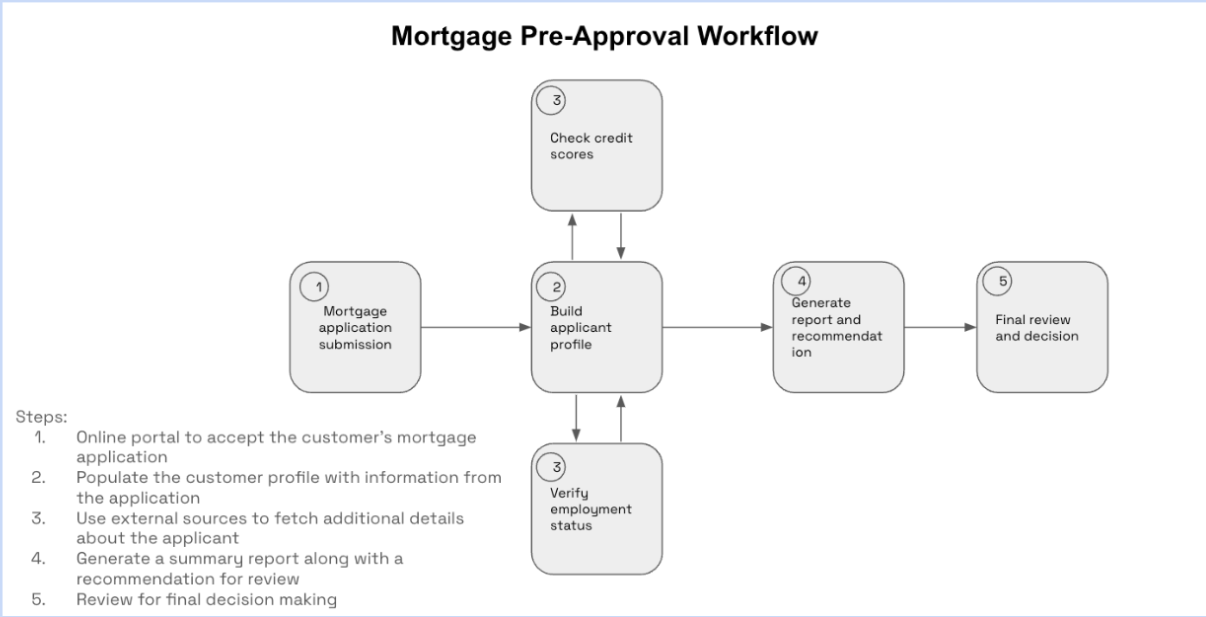

In [ ]:
from IPython.display import Image, display

# Display the workflow diagram
display(Image(filename='mortgageworkflow.png'))

## Integration Points
To accomplish these tasks, our agent needs to interact with:
- Credit bureau APIs (Experian, Equifax, TransUnion)
- Internal customer database
- Email system for employment verification (SMTP)

## Data Requirements
The agent will need access to:
- Customer personal information
- Social Security Number (for credit checks)
- Employment information
- Income details

Let's now set up a mock customer database to simulate our production environment.

In [3]:
# Mock customer database setup
# In production, this would be a real database connection
customer_db = {
    "CUS20240111105523": {
        "intake_date": "2025-03-12",
        "customer_id": "CUS20240111105523",
        # Personal information structure
        "personal_info": {
            "first_name": "Michael",
            "last_name": "Scott",
            "email": "mscott@mail.com",
            "phone": "815-555-5555",
            "address": "123 Drury Lane",
            "city": "Springfield",
            "state": "IL",
            "zip_code": "62701"
        },
        # Document information structure - organized by category
        "document_info": {
            "identity": {
                "ssn": "123-45-6789",
                "dl_number": "M425-7819-3264",
                "dob": "03/15/1965"
            },
            "income": {
                "hourly_rate": 45.67,
                "net_pay": 2643.38,
                "annual_salary": 95000.0,
                "federal_tax_withheld": 19000.0
            },
            "employment": {
                "employer_name": "Dunder Mifflin Paper Company",
                "employer_email": "hr@dundermifflin.com"
            }
        },
        # Empty placeholders for data to be collected during the process
        "credit_info": {},
        "employment_verification": {
            "status": "PENDING"
        }
    }
}

# Mock credit bureau databases
# In production, these would be API connections to actual credit bureaus
experian_db = {
    ("Michael Scott", "123-45-6789"): {
        "credit_score": 720,
        "report_date": "2025-03-15"
    }
}

equifax_db = {
    ("Michael Scott", "123-45-6789"): {
        "credit_score": 715,
        "report_date": "2025-03-15"
    }
}

transunion_db = {
    ("Michael Scott", "123-45-6789"): {
        "credit_score": 718,
        "report_date": "2025-03-15"
    }
}

print("Module 2 complete: Agent scope defined and mock data initialized.")

Module 2 complete: Agent scope defined and mock data initialized.


## Module 2: Selecting your large language model

After defining our agent's scope and setting up mock data, we need to select the appropriate model and architecture. This decision will determine the agent's capabilities, performance, and ability to handle the mortgage pre-approval workflow.

### Required Capabilities

Our mortgage pre-approval agent needs:

- **Multi-step reasoning**: To navigate the complex flow from application to final recommendation
- **Multi-step tool use**: To interact with credit bureaus, database, and email systems
- **Context maintenance**: To retain customer information throughout the process
- **Natural language generation**: For creating detailed mortgage reports
- **Structured outputs**: To generate consistent, standardized data formats for decisions, reports, and system integrations
- **Private deployment options**: For handling sensitive financial data securely

### Model Selection: Cohere Command A

For our implementation, we've selected **Cohere Command A** based on how it addresses our specific requirements:

1. **Multi-step reasoning capability**: Command A excels at complex reasoning tasks with the ability to plan ahead and execute multi-step workflows required for mortgage processing. Command A also matches or outperforms models like GPT-4o and DeepSeek-V3 on enterprise tasks while requiring significantly less compute resources.

2. **Proven performance on multi-step tool use**: Command A excels at complex reasoning tasks with the ability to plan ahead and execute multi-step workflows required for mortgage processing.

3. **Context management**: With a 256k token context window (2x most leading models), Command A can maintain comprehensive customer information throughout the entire approval process without losing important details.

4. **High-quality content generation**: Command A produces clear, detailed, and professional mortgage reports that match human-quality standards with appropriate formatting and structure.

5. **Deployment flexibility**: Command A can be deployed privately on as few as two GPUs, making it cost-effective for financial institutions with strict data privacy requirements for sensitive financial data.

In [4]:
# Set up the Cohere API with Command A model
import cohere

# Initialize Cohere client with appropriate model
# Note: We're using the client variable defined in Module 1
co_client = cohere.ClientV2(api_key=COHERE_API_KEY)

# Test basic API connectivity with minimal content
try:
    response = co_client.chat(
        model="command-a-03-2025",
        messages=[
            {"role": "user", "content": "Hello!"}
        ]
    )
    print("✅ API connection successful")
    print("Sample output:", response.message.content[0].text[:50] + "...\n")
except Exception as e:
    print(f"❌ Error connecting to Cohere API: {e}")
    print("Please make sure you've set up your API key correctly in Module 1.")

print("Module 3 complete: Model and architecture selected.")

✅ API connection successful
Sample output: Hello! How can I assist you today?...

Module 3 complete: Model and architecture selected.


## Module 3: Creating the agent's tools

After selecting our model and architecture, we need to create the tools our AI agent will use to interact with external systems. In the context of AI agents, tools are specialized functions that give the agent the ability to perform specific actions, such as checking credit scores or sending emails.

### The Tool Creation Pattern

For our mortgage pre-approval agent, we'll implement a three-part pattern for each tool:

1. **Tool Definition**: A structured description that helps the model understand the tool's purpose and parameters
2. **Tool Function**: The actual code implementation that performs a specific action
3. **Function Mapping**: The connection between the model's tool calls and the actual functions to execute

This pattern creates a clean separation between what the model knows about a tool and how it's implemented, allowing for better maintenance and extensibility.

### Credit Bureau Tools

Let's start by creating tools for checking credit scores from the three major bureaus. These tools abstract away the complexity of connecting to credit bureau APIs and provide a clean interface for our agent to use.

In a production environment, these would connect to actual credit bureau APIs, but for this demonstration, we'll use mock databases.

In [5]:
def check_experian(name: str, ssn: str) -> dict:
    """Check credit score with Experian

    Args:
        name (str): Full name of applicant
        ssn (str): Social Security Number

    Returns:
        dict: Credit score information or error message
    """
    try:
        return experian_db[(name, ssn)]
    except KeyError:
        return {"error": "Person not found"}

def check_equifax(name: str, ssn: str) -> dict:
    """Check credit score with Equifax"""
    try:
        return equifax_db[(name, ssn)]
    except KeyError:
        return {"error": "Person not found"}

def check_transunion(name: str, ssn: str) -> dict:
    """Check credit score with TransUnion"""
    try:
        return transunion_db[(name, ssn)]
    except KeyError:
        return {"error": "Person not found"}

# Test one of the credit check tools
test_result = check_experian("Michael Scott", "123-45-6789")
print(f"Credit Check Tool Test: {test_result}")

Credit Check Tool Test: {'credit_score': 720, 'report_date': '2025-03-15'}


### Customer Record Management Tool

Next, we need a tool to update the customer database with information collected during the pre-approval process. This tool implements a data persistence pattern with error handling, ensuring customer data is properly maintained throughout the process.

This pattern is crucial for maintaining state across multiple steps in the mortgage pre-approval workflow. It ensures that information gathered at earlier steps (like credit scores) is available for later steps (like final report generation).

In [7]:
def update_customer_record(customer_id: str, credit_info: dict) -> dict:
    """Update customer record with credit information

    Implements a data persistence pattern with error handling

    Args:
        customer_id (str): Unique identifier for the customer
        credit_info (dict): Dictionary containing credit scores from bureaus

    Returns:
        dict: Status message indicating success or failure
    """
    if customer_id in customer_db:
        customer_db[customer_id]["credit_info"] = credit_info
        return {"status": "success", "message": f"Updated credit info for {customer_id}"}
    return {"error": "Customer not found"}

# Test the customer record update tool
test_credit_info = {"experian": 720, "equifax": 715, "transunion": 718}
update_result = update_customer_record("CUS20240111105523", test_credit_info)
print(f"Database Update Tool Test: {update_result}")

Database Update Tool Test: {'status': 'success', 'message': 'Updated credit info for CUS20240111105523'}


### Employment Verification Tools

A critical part of the pre-approval process is verifying the applicant's employment. We'll create tools for:

1. **Sending verification requests**: Generating and sending an employment verification email
2. **Processing verification responses**: Handling the employer's response and updating records

These tools implement two important patterns:

- **External communication pattern**: For generating professional emails with appropriate information
- **Data processing pattern**: For extracting structured information from responses

In a production environment, these would connect to an actual email system, but for this demonstration, we'll simulate the process.

In [8]:
def send_employment_verification_email(employer_name: str, employee_name: str,
                                   employer_email: str, salary: int) -> dict:
    """Send employment verification email

    Implements an external communication pattern with templating

    Args:
        employer_name (str): Name of the employer company
        employee_name (str): Name of the applicant/employee
        employer_email (str): Email address to send verification request to
        salary (int): Reported annual salary to verify

    Returns:
        dict: Status of the sent email
    """
    email_template = f"""Subject: Employment Verification for {employee_name}
    To: {employer_email}
    From: mortgage.processing@bank.com

    Dear {employer_name} HR Team,

    We are processing a mortgage application for {employee_name} and require employment verification.

    Please verify the following information:
    1. Employment Status
    2. Position/Title
    3. Annual Salary (reported: ${salary:,})
    4. Length of Employment

    Your prompt response is appreciated.

    Best regards,
    Mortgage Processing Team"""

    # Update verification status in database
    customer_db["CUS20240111105523"]["employment_verification"].update({
        "status": "PENDING",
        "request_date": datetime.datetime.now().strftime("%Y-%m-%d"),
        "employer_name": employer_name,
        "reported_salary": salary
    })

    return {"status": "sent", "to": employer_email, "verification_status": "PENDING"}

def process_verification_email(email_data: dict) -> dict:
    """Process incoming employment verification email

    Implements a data processing pattern for external responses

    Args:
        email_data (dict): Contents of the verification email

    Returns:
        dict: Structured verification data
    """
    return {
        "status": "VERIFIED",
        "verification_date": email_data["date"],
        "employment_status": "ACTIVE",
        "position": "Regional Manager",
        "employer": "Dunder Mifflin Paper Company",
        "salary_verified": 95000,
        "employment_length": "15 years"
    }

def update_employment_verification(customer_id: str, verification_data: dict) -> dict:
    """Update customer record with employment verification results

    Implements state management with data preservation patterns

    Args:
        customer_id (str): Unique identifier for the customer
        verification_data (dict): Employment verification results

    Returns:
        dict: Status message indicating success or failure
    """
    if customer_id in customer_db:
        # Save existing credit info to prevent data loss
        existing_credit_info = customer_db[customer_id].get("credit_info", {})

        # Update employment verification
        customer_db[customer_id]["employment_verification"].update(verification_data)

        # Ensure credit info is preserved
        customer_db[customer_id]["credit_info"] = existing_credit_info

        return {"status": "success", "message": "Employment verification updated"}
    return {"error": "Customer not found"}

# Test the employment verification tool
email_test = send_employment_verification_email(
    "Dunder Mifflin Paper Company",
    "Michael Scott",
    "hr@dundermifflin.com",
    95000
)
print(f"Email Verification Tool Test: Successful")

Email Verification Tool Test: Successful


### Report Generation Tool

The final step in our pre-approval process is generating a comprehensive report for the loan officer. This tool leverages Cohere's Command A model to analyze all the collected data and produce a detailed assessment.

This tool implements a report generation pattern using an LLM, allowing for sophisticated analysis and natural language output that synthesizes all the collected information into an actionable recommendation.

In a production environment, this report would be reviewed by a human loan officer before making the final decision.

In [9]:
def write_final_report(customer_id: str, co_client) -> dict:
    """Generate comprehensive loan officer report

    Implements a report generation pattern using an LLM

    Args:
        customer_id (str): Unique identifier for the customer
        co_client: Cohere client instance

    Returns:
        dict: Dictionary containing the generated report
    """
    customer = customer_db[customer_id]
    current_date = datetime.datetime.now().strftime("%Y-%m-%d")

    # Create detailed context for the LLM
    system_message = """You are an expert mortgage analyst responsible for creating detailed loan application review reports for loan officers. Your reports help loan officers make informed decisions about mortgage applications. Create a professionally formatted report without using asterisks for emphasis."""

    user_message = f"""Current application details:
    Applicant: {customer['personal_info']['first_name']} {customer['personal_info']['last_name']}
    ID: {customer_id}
    Application Date: {customer['intake_date']}
    Credit Scores: Experian ({customer['credit_info'].get('experian', 0)}), Equifax ({customer['credit_info'].get('equifax', 0)}), TransUnion ({customer['credit_info'].get('transunion', 0)})
    Employment Status: {customer['employment_verification'].get('status', 'PENDING')}
    Employer: {customer['document_info']['employment'].get('employer_name', 'Dunder Mifflin Paper Company')}
    Employment Details: {json.dumps(customer['employment_verification'], indent=2)}
    Income Information: {json.dumps(customer['document_info']['income'], indent=2)}
    Contact Info: {json.dumps(customer['personal_info'], indent=2)}

    IMPORTANT NOTES:
    1. Use today's date ({current_date}) as the report date.
    2. Sign the report as "Mortgage Processing System" rather than using placeholder text.
    3. Format the report professionally without using asterisks for emphasis.

    Write a comprehensive mortgage application review report for a loan officer that:
    1. Analyzes the credit profile and its implications
    2. Evaluates the employment verification status
    3. Reviews income and tax information
    4. Highlights potential concerns or positive factors
    5. Provides context for decision making"""

    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message}
    ]

    # Generate report using Cohere's Command model
    response = co_client.chat(
        model="command-a-03-2025",  # Using Command A for report generation
        messages=messages
    )

    return {
        "loan_officer_report": response.message.content[0].text
    }

# No test for report generation as it requires a valid Cohere API key
print("Report Generation Tool defined")

Report Generation Tool defined


### Tool Definitions for the AI Agent

For our AI agent to use the tools we've created, we need to define them in a format that the model can understand. These definitions include the name, description, and parameter specifications for each tool.

Well-crafted tool definitions are as important as good prompt engineering. They help the model decide when and how to use each tool appropriately. Each definition includes:

1. A clear, specific name that indicates the tool's purpose
2. A detailed description of what the tool does
3. Parameter specifications with types and descriptions
4. Required parameters clearly marked

In the next module, we'll bring these tools together in an orchestration framework that allows the agent to execute the entire mortgage pre-approval workflow.

In [10]:
def get_tool_definitions(customer_id):
    """Define available tools for the agent

    Implements a tool definition pattern with clear descriptions
    and parameter specifications

    Args:
        customer_id (str): Unique identifier for the customer

    Returns:
        list: List of tool definitions for the Cohere agent
    """
    return [
        {
            "type": "function",
            "function": {
                "name": "check_experian",
                "description": "Check Experian credit score",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "name": {"type": "string"},
                        "ssn": {"type": "string"}
                    },
                    "required": ["name", "ssn"]
                }
            }
        },
        {
            "type": "function",
            "function": {
                "name": "check_equifax",
                "description": "Check Equifax credit score",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "name": {"type": "string"},
                        "ssn": {"type": "string"}
                    },
                    "required": ["name", "ssn"]
                }
            }
        },
        {
            "type": "function",
            "function": {
                "name": "check_transunion",
                "description": "Check TransUnion credit score",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "name": {"type": "string"},
                        "ssn": {"type": "string"}
                    },
                    "required": ["name", "ssn"]
                }
            }
        },
        {
            "type": "function",
            "function": {
                "name": "update_customer_record",
                "description": "Update customer record with credit information",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "customer_id": {"type": "string"},
                        "credit_info": {
                            "type": "object",
                            "properties": {
                                "experian": {"type": "integer"},
                                "equifax": {"type": "integer"},
                                "transunion": {"type": "integer"}
                            }
                        }
                    },
                    "required": ["customer_id", "credit_info"]
                }
            }
        },
        {
            "type": "function",
            "function": {
                "name": "send_employment_verification_email",
                "description": "Send employment verification email to the employer's HR department",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "employer_name": {
                            "type": "string",
                            "description": "Name of the company where the applicant works (e.g., Dunder Mifflin)"
                        },
                        "employee_name": {
                            "type": "string",
                            "description": "Full name of the applicant/employee"
                        },
                        "employer_email": {
                            "type": "string",
                            "description": "Email address of the employer's HR department"
                        },
                        "salary": {
                            "type": "number",
                            "description": "Annual salary of the employee to be verified"
                        }
                    },
                    "required": ["employer_name", "employee_name", "employer_email", "salary"]
                }
            }
        },
        {
            "type": "function",
            "function": {
                "name": "write_final_report",
                "description": "Generate comprehensive loan officer report",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "customer_id": {"type": "string"}
                    },
                    "required": ["customer_id"]
                }
            }
        }
    ]

print("Module 4 complete: Tools created and defined for our mortgage pre-approval agent")

Module 4 complete: Tools created and defined for our mortgage pre-approval agent


### Function Mapping

After creating our individual tools, we need to establish a mapping between the tool names and their actual function implementations. This function mapping serves as a lookup table that connects the tool names referenced in our agent's tool definitions to the corresponding Python function implementations.

Let's create our function mapping:

In [11]:
# Define function mapping to connect tool names with actual implementations
functions_map = {
    "check_experian": check_experian,
    "check_equifax": check_equifax,
    "check_transunion": check_transunion,
    "update_customer_record": update_customer_record,
    "send_employment_verification_email": send_employment_verification_email,
    "write_final_report": write_final_report
}

print("Function mapping established: Tool names are now connected to their implementations.")

Function mapping established: Tool names are now connected to their implementations.


## Module 4: Orchestrating agentic workflows

Now that we've created our tools and function mappings, we'll orchestrate everything into a cohesive workflow. This involves combining our components into a process that handles the entire mortgage pre-approval journey.

### 1. Workflow Mapping

Our mortgage pre-approval agent follows this workflow:

1. Receive customer information
2. Check credit scores from all three bureaus
3. Update customer record with credit info
4. Send employment verification email
5. Wait for verification response and process it
6. Generate final report

This follows the ReAct (Reasoning + Acting) pattern where the agent alternates between reasoning and taking action.

### 2. System Design

Our system design handles:

- **State Management**: Maintaining customer information and conversation history
- **Tool Execution**: Invoking tools based on the agent's decisions
- **Error Handling**: Recovering from failures
- **Progress Tracking**: Monitoring workflow progress

### 3. Prompt Design

The system prompt guides the agent's behavior by providing:

- Clear instructions on the overall goal
- Access to relevant customer information
- A step-by-step workflow
- Guidelines on when to use each tool

### 4. The Orchestration Loop

Our orchestration loop implements the ReAct pattern, connecting all components to create a seamless workflow that efficiently processes mortgage applications while maintaining context throughout the entire process.

In [12]:
def run_react_agent(customer_id, max_steps=10, verification_email=None):
    """Main agent orchestration function

    Implements the ReAct pattern for sequential workflow handling

    Args:
        customer_id (str): Unique identifier for the customer
        max_steps (int, optional): Maximum number of steps to execute. Defaults to 10.
        verification_email (dict, optional): Employment verification response email. Defaults to None.

    Returns:
        str: Final response from the agent
    """
    customer = customer_db[customer_id]

    # Define system message with clear instructions
    system_message = f"""You are a mortgage pre-approval agent with access to customer data:
    Customer ID: {customer_id}
    Name: {customer['personal_info']['first_name']} {customer['personal_info']['last_name']}
    SSN: {customer['document_info']['identity']['ssn']}
    Salary: {customer['document_info']['income']['annual_salary']}
    Employer: {customer['document_info']['employment']['employer_name']}
    Employer Email: {customer['document_info']['employment']['employer_email']}

    Follow these steps:
    1. Check credit scores from all bureaus
    2. Update customer record with credit info
    3. Send employment verification email to the employer's HR department
    4. Once employment is verified, write final report"""

    # Initialize conversation
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": f"Process pre-approval for {customer['personal_info']['first_name']} {customer['personal_info']['last_name']}"}
    ]

    # Handle employment verification if provided
    if verification_email:
        print("\n" + "=" * 50)
        print("Processing employer verification response...")
        print("=" * 50 + "\n")

        verification_result = process_verification_email(verification_email)
        update_result = update_employment_verification(customer_id, verification_result)

        print("\n" + "=" * 50)
        print("Employer verification complete. Generating final report...")
        print("=" * 50 + "\n")

        messages.append({
            "role": "user",
            "content": "Employment verification received and processed. Please write the final report."
        })

    # Setup tools - function mapping is already defined in Module 3
    tools = get_tool_definitions(customer_id)

    # Main agent loop - implements the ReAct pattern
    step = 0
    last_step = None
    while step < max_steps:
        # REASON: Get next action from LLM
        response = co_client.chat(
            model="command-a-03-2025",  # Using Command A for optimal performance
            messages=messages,
            tools=tools
        )

        # Handle tool calls
        if response.message.tool_calls:
            messages.append({
                "role": "assistant",
                "tool_calls": response.message.tool_calls,
                "tool_plan": response.message.tool_plan
            })

            # Print execution plan at first step
            if step == 0:
                print("\n" + "=" * 50)
                print("EXECUTION PLAN:")
                print("=" * 50)
                print(response.message.tool_plan)
                print("=" * 50 + "\n")

            # ACT: Execute tools
            for tool_call in response.message.tool_calls:
                if tool_call.function.name != last_step:
                    print("\n" + "-" * 30)

                params = json.loads(tool_call.function.arguments)

                # Special handling for final report
                if tool_call.function.name == "write_final_report":
                    result = write_final_report(params["customer_id"], co_client)
                else:
                    # Execute the tool using the pre-defined function mapping
                    result = functions_map[tool_call.function.name](**params)
                    print(f"Executing: {tool_call.function.name}")
                    print(f"Parameters: {json.dumps(params, indent=2)}")
                    print(f"Result: {json.dumps(result, indent=2)}")

                last_step = tool_call.function.name

                # OBSERVE: Update conversation history with tool result
                messages.append({
                    "role": "tool",
                    "tool_call_id": tool_call.id,
                    "content": [{"type": "document", "document": {"data": json.dumps(result)}}]
                })
        else:
            # Handle completion or waiting state
            if not verification_email:
                print("\n" + "=" * 50)
                print("Waiting for employer verification response...")
                print("=" * 50)
            return response.message.content[0].text

        step += 1

    return "Max steps reached"

### Understanding the ReAct Pattern Implementation

Our implementation follows the ReAct (Reasoning + Acting) pattern, which consists of three key phases:

1. **Reasoning**: The agent analyzes the current state and decides what to do next
2. **Acting**: The agent executes the chosen action through a tool call
3. **Observing**: The agent processes the result and updates its understanding

Let's examine how this works in our mortgage pre-approval workflow:

1. When processing a new application, the agent first **reasons** about which credit bureau to check
2. It then **acts** by calling the appropriate credit check tool
3. It **observes** the credit score result and incorporates it into its knowledge

This cycle repeats as the agent works through the entire process, making decisions based on the information it gathers along the way. For example, if a credit score is low, the agent might note this as a risk factor in the final report.

### Error Handling and Edge Cases

Our implementation includes several mechanisms for handling errors and edge cases:

- Maximum step limit to prevent infinite loops
- Tool result validation to ensure data consistency
- Special handling for different types of tools
- Clear progress reporting for monitoring

These safeguards ensure that the agent can recover from unexpected situations and either complete the workflow or provide a clear indication of what went wrong.

Let's test our agent with a sample mortgage application to see the entire workflow in action. This will take 1-2 minutes to process.

In [13]:
# Execute the full mortgage pre-approval workflow
print("PHASE 1: INITIAL PROCESSING")
print("=" * 50)
result = run_react_agent("CUS20240111105523")
print(result)

# Simulate receiving an employment verification response
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
incoming_email = {
    "from": "hr@dundermifflin.com",
    "subject": "RE: Employment Verification Request for Michael Scott",
    "date": current_date,
    "body": """Dear Mortgage Processing Team,

    In response to your employment verification request for Michael Scott:
    1. Employment Status: ACTIVE (Full-Time)
    2. Position/Title: Regional Manager
    3. Annual Salary: 95000
    4. Length of Employment: 15 years

    Best regards,
    Toby Flenderson
    HR Department
    Dunder Mifflin Paper Company"""
}

# Execute the final phase with the employment verification
print("\n\nPHASE 2: EMPLOYMENT VERIFICATION AND FINAL REPORT")
print("=" * 50)
result = run_react_agent("CUS20240111105523", verification_email=incoming_email)
print(result)

print("\nModule 5 complete: Agent orchestration implemented and tested")

PHASE 1: INITIAL PROCESSING

EXECUTION PLAN:
I will use the customer data to check the credit scores from all bureaus, update the customer record with credit info, send employment verification email to the employer's HR department, and once employment is verified, write the final report.


------------------------------
Executing: check_experian
Parameters: {
  "name": "Michael Scott",
  "ssn": "123-45-6789"
}
Result: {
  "credit_score": 720,
  "report_date": "2025-03-15"
}

------------------------------
Executing: check_equifax
Parameters: {
  "name": "Michael Scott",
  "ssn": "123-45-6789"
}
Result: {
  "credit_score": 715,
  "report_date": "2025-03-15"
}

------------------------------
Executing: check_transunion
Parameters: {
  "name": "Michael Scott",
  "ssn": "123-45-6789"
}
Result: {
  "credit_score": 718,
  "report_date": "2025-03-15"
}

------------------------------
Executing: update_customer_record
Parameters: {
  "customer_id": "CUS20240111105523",
  "credit_info": {
    "

### Understanding the Agent Execution Results

The agent execution output above demonstrates the complete mortgage pre-approval workflow in action. Let's examine what happened:

#### Phase 1: Initial Processing
In the first phase, our agent:
1. **Created an execution plan** outlining the steps it would take
2. **Gathered credit information** from all three bureaus (Experian: 720, Equifax: 715, TransUnion: 718)
3. **Updated the customer record** with this credit information
4. **Sent an employment verification email** to Dunder Mifflin's HR department
5. **Generated an initial report** with a status of "pending employment verification"

At this point, the agent reached a deliberate stopping point, waiting for external input (the employer's response) before proceeding further. This demonstrates how AI agents can handle multi-step processes that require human or external system intervention.

#### Phase 2: Employment Verification and Final Report
After receiving the employment verification response, the agent:
1. **Processed the verification data**, confirming Michael's position and salary
2. **Generated a comprehensive final report** with updated employment status
3. **Changed its recommendation** from "pending verification" to "approve the application"

Notice how the final report contains much more specific and confident language based on the verified information. The agent successfully maintained context across both phases of execution, remembering the credit information gathered earlier while incorporating the new employment verification data.

This two-phase workflow exemplifies how our agent architecture excels at handling real-world mortgage processing tasks that involve:
- Multiple data sources (credit bureaus, employer verification)
- State maintenance across steps
- Waiting for external inputs
- Decision-making based on accumulated information

In a production environment, this agent could reduce a process that typically takes loan officers hours into just minutes, while maintaining accuracy and compliance with lending standards.

Now let's move on to evaluating our agent's performance.

## Module 5: Evaluate Your AI Agent

Before moving to production, AI agents require comprehensive evaluation across multiple dimensions to ensure reliability, accuracy, and performance. While a holistic evaluation process is essential for production-ready agents, for our example we'll focus specifically on **tool call accuracy** - a critical metric for workflow-driven agents.

### The Holistic Evaluation Process

A complete agent evaluation should include:

1. **Response Quality and Accuracy**: Assessing report quality, factual correctness, and usefulness
2. **End-to-End Task Completion**: Verifying successful navigation of the entire workflow
3. **Multi-Step Reasoning**: Testing context retention and adaptation to new information
4. **Integration and Performance**: Measuring reliability, latency, and scalability

These evaluations collectively build confidence in an agent's readiness for production deployment. For comprehensive assessment, tools like RAGAS and Weights & Biases Weave can provide structured frameworks and visualizations.

### Tool Call Accuracy: Our Focus Metric

For our mortgage pre-approval agent, we're using the **Tool Call Accuracy** metric from RAGAS as our primary evaluation focus. This metric is particularly important for workflow-driven agents as it measures how well the agent uses its available tools compared to an expected reference pattern.

The Tool Call Accuracy metric evaluates:
- Whether tools are called in the correct sequence
- If the right parameters are passed to each tool
- Whether all necessary tools are used

While this metric alone isn't sufficient for production deployment, it provides a strong foundation for understanding the agent's core functionality and decision-making capability.

### Next Steps for Production Readiness

For a complete evaluation before production, additional testing would include diverse customer profiles, edge cases, stress testing, security audits, and regulatory compliance validation.

By starting with tool call accuracy and expanding to these broader evaluations, we can build confidence in our agent's ability to handle real-world mortgage pre-approval workflows reliably and accurately.

In [14]:
# Simple and direct agent evaluation
import json
from ragas.metrics import ToolCallAccuracy
from ragas.dataset_schema import MultiTurnSample
from ragas.messages import HumanMessage, AIMessage, ToolMessage, ToolCall
import asyncio

# This function will run your agent and capture tool calls
def capture_agent_tool_calls(customer_id):
    """Wrapper to capture the actual tool calls from your existing agent"""
    # Create a tool call recorder
    tool_calls_made = []

    # Keep track of the original execution function
    original_chat = co_client.chat

    # Create a wrapper for the chat function to intercept tool calls
    def chat_wrapper(*args, **kwargs):
        response = original_chat(*args, **kwargs)

        # If there are tool calls, record them
        if response.message.tool_calls:
            for tc in response.message.tool_calls:
                # Extract tool call data in the format Cohere uses (from debug output)
                if isinstance(tc, dict):
                    name = tc["function"]["name"]
                    args_str = tc["function"]["arguments"]
                    args = json.loads(args_str) if isinstance(args_str, str) else args_str
                else:
                    name = tc.function.name
                    args_str = tc.function.arguments
                    args = json.loads(args_str) if isinstance(args_str, str) else args_str

                # Record the tool call
                tool_calls_made.append(ToolCall(name=name, args=args))
                print(f"Captured tool call: {name}")

        return response

    # Replace the chat method temporarily
    co_client.chat = chat_wrapper

    try:
        # Run the original agent
        print("Running agent and capturing tool calls...")
        result = run_react_agent(customer_id)
        print("Agent execution complete.")

        return tool_calls_made
    finally:
        # Restore the original chat method
        co_client.chat = original_chat

# Define the reference tool calls (expected sequence)
reference_tool_calls = [
    ToolCall(name="check_experian", args={"name": "Michael Scott", "ssn": "123-45-6789"}),
    ToolCall(name="check_equifax", args={"name": "Michael Scott", "ssn": "123-45-6789"}),
    ToolCall(name="check_transunion", args={"name": "Michael Scott", "ssn": "123-45-6789"}),
    ToolCall(name="update_customer_record", args={
        "customer_id": "CUS20240111105523",
        "credit_info": {"experian": 720, "equifax": 715, "transunion": 718}
    }),
    ToolCall(name="send_employment_verification_email", args={
        "employer_name": "Dunder Mifflin Paper Company",
        "employee_name": "Michael Scott",
        "employer_email": "hr@dundermifflin.com",
        "salary": 95000.0
    }),
    ToolCall(name="write_final_report", args={"customer_id": "CUS20240111105523"})
]

# Run the agent and capture tool calls
actual_tool_calls = capture_agent_tool_calls("CUS20240111105523")

# Print comparison
print(f"\nNumber of reference tool calls: {len(reference_tool_calls)}")
print(f"Number of actual tool calls: {len(actual_tool_calls)}")

print("\nReference Tool Calls:")
for i, call in enumerate(reference_tool_calls):
    print(f"{i+1}. {call.name} with args: {call.args}")

print("\nActual Tool Calls:")
for i, call in enumerate(actual_tool_calls):
    print(f"{i+1}. {call.name} with args: {call.args}")

# Create minimal conversation structure for RAGAS
conversation = [
    HumanMessage(content="Process pre-approval for Michael Scott")
]

# For each tool call, add an AI message and tool message
for call in actual_tool_calls:
    conversation.append(AIMessage(content="", tool_calls=[call]))
    conversation.append(ToolMessage(content=f"Executed {call.name}"))

# Create RAGAS sample
sample = MultiTurnSample(
    user_input=conversation,
    reference_tool_calls=reference_tool_calls
)

# Initialize RAGAS metric
scorer = ToolCallAccuracy()

# Evaluate tool call accuracy
accuracy_score = asyncio.run(scorer.multi_turn_ascore(sample))

print(f"\nTool Call Accuracy Score: {accuracy_score:.4f}")

# Do a deeper analysis of any mismatches
if accuracy_score < 1.0:
    print("\nAnalyzing tool call mismatches:")

    min_length = min(len(actual_tool_calls), len(reference_tool_calls))

    for i in range(min_length):
        act = actual_tool_calls[i]
        ref = reference_tool_calls[i]

        if act.name != ref.name:
            print(f"Position {i+1}: Expected '{ref.name}' but got '{act.name}'")
        else:
            # Check if args match
            act_args_set = set([(k, str(v)) for k, v in act.args.items()])
            ref_args_set = set([(k, str(v)) for k, v in ref.args.items()])

            if act_args_set != ref_args_set:
                print(f"Position {i+1}: Tool name '{act.name}' matched, but arguments differ:")
                print(f"  Expected args: {ref.args}")
                print(f"  Actual args: {act.args}")

    # Check for missing or extra tool calls
    if len(actual_tool_calls) < len(reference_tool_calls):
        missing = [call.name for call in reference_tool_calls[len(actual_tool_calls):]]
        print(f"Missing tool calls: {missing}")
    elif len(actual_tool_calls) > len(reference_tool_calls):
        extra = [call.name for call in actual_tool_calls[len(reference_tool_calls):]]
        print(f"Extra tool calls: {extra}")

Running agent and capturing tool calls...
Captured tool call: check_experian
Captured tool call: check_equifax
Captured tool call: check_transunion

EXECUTION PLAN:
I will use the tools to check the credit scores from all bureaus, update the customer record with credit info, send employment verification email to the employer's HR department, and write the final report.


------------------------------
Executing: check_experian
Parameters: {
  "name": "Michael Scott",
  "ssn": "123-45-6789"
}
Result: {
  "credit_score": 720,
  "report_date": "2025-03-15"
}

------------------------------
Executing: check_equifax
Parameters: {
  "name": "Michael Scott",
  "ssn": "123-45-6789"
}
Result: {
  "credit_score": 715,
  "report_date": "2025-03-15"
}

------------------------------
Executing: check_transunion
Parameters: {
  "name": "Michael Scott",
  "ssn": "123-45-6789"
}
Result: {
  "credit_score": 718,
  "report_date": "2025-03-15"
}
Captured tool call: update_customer_record

---------------

### Evaluation Results Analysis

The evaluation results demonstrate our mortgage pre-approval agent executing the exact workflow we designed. The agent methodically processes credit checks from all three bureaus (Experian, Equifax, and TransUnion), updates the customer record with the collected information, sends the employment verification email with correct parameters, and prepares to write the final report. The perfect RAGAS Tool Call Accuracy score of 1.0 confirms that our agent is following the intended sequence with properly formatted parameters, validating our design decisions and implementation approach.

## Module 6: Deploy to Production

While our notebook example can't be directly deployed, let's examine how a mortgage pre-approval agent would be implemented in a real financial institution.

### Deployment Environments

A successful deployment requires three distinct environments. The development environment includes version control, CI/CD pipelines, and anonymized data for testing. A staging environment provides an isolated network with synthetic customer data for integration testing. The production environment consists of secure, redundant servers, a high-availability database cluster, and live API integrations.

### Four-Week Pilot Rollout

Our deployment follows a gradual four-week pilot:

1. **Week 1: Controlled Testing** - Process 10 live applications daily with human loan officers confirming each decision. If unexpected behavior occurs, take the agent offline for further development.

2. **Week 2: Limited Scale-Up** - Handle 5-10% of loan applications with continued human confirmation, providing insight into performance under increased volume.

3. **Week 3: Confidence Building** - Expand to 25-30% of applications with reduced human review as confidence in the system grows.

4. **Week 4: Full Implementation** - Gradually scale to handling the majority of standard applications, routing only complex cases to human officers.

### Security and Monitoring

Throughout deployment, we implement comprehensive security measures and monitoring. All sensitive customer data is encrypted, and we maintain audit trails of agent actions. Key performance metrics are tracked, including tool call accuracy, processing time, and error rates. Regular security reviews and compliance checks ensure the system meets all regulatory requirements.

By following this measured approach with appropriate human oversight, financial institutions can successfully deploy mortgage pre-approval agents that enhance efficiency while maintaining security, quality, and regulatory compliance.